In [9]:
from pyspark.sql import SparkSession

from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import numpy as np
import random
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pyspark
print(pyspark.__version__)
from pyspark.ml.linalg import DenseVector

2.4.4


In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Assign2").getOrCreate()    
spark.conf.set("spark.executor.memory", '30g')
spark.conf.set("spark.driver.memory",'30g')


### Part 1

In [3]:
sparkDF = spark.read.csv("MSD.txt",header=False,sep=",",inferSchema=True).limit(100)

In [12]:
# Define the `input_data` 
input_data = sparkDF.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

# Replace `df` with the new DataFrame
MSDDf = spark.createDataFrame(input_data, ["label", "features"])

In [13]:
train, validation , test = MSDDf.randomSplit([0.7, 0.1, 0.2],seed = 42)

### Part 2

#### Train our model on training data and evaluate the model based on validation set

In [33]:
lr = LinearRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)

In [34]:
predictions = lrModel.transform(validation)
predictions.select("prediction", "label").show(5)

+------------------+-----+
|        prediction|label|
+------------------+-----+
|2002.8645263350766| 2000|
|2001.4568370234836| 2000|
|2000.4496332324131| 2000|
|2003.6166814788482| 2001|
|2001.7877172976298| 2003|
+------------------+-----+
only showing top 5 rows



In [35]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
 # summary only

Root Mean Squared Error (RMSE) on test data = 3.39884


### Part 3

#### Visualize the log of the training error as a function of iteration. The scatter plot visualizes the logarithm of the training error for all 50 iterations. 

Text(0, 0.5, 'Iterations')

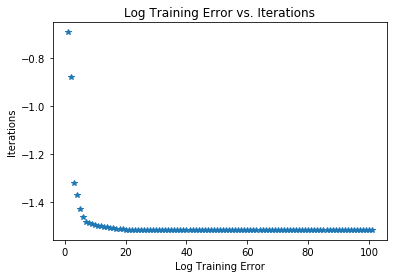

In [39]:
iterations = list(range(1,lrModel.summary.totalIterations + 1))
lossHistory = np.log(lrModel.summary.objectiveHistory)
plt.plot(iterations,lossHistory,'*')
plt.title('Log Training Error vs. Iterations')
plt.xlabel('Log Training Error')
plt.ylabel('Iterations')

### Part 4
#### Use this model for prediction on test data. Calculate Root Mean Square Error of our model.

In [40]:
predictionsTest = lrModel.transform(test)
predictionsTest.select("prediction", "label").show(5)

rmse = evaluator.evaluate(predictionsTest)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+-----+
|        prediction|label|
+------------------+-----+
|2002.2261002143748| 1992|
|1998.9425979423122| 1996|
|2004.8193453487095| 1997|
| 2000.082552245115| 1997|
|2001.3937676782425| 1999|
+------------------+-----+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 3.91982
